# **Basic Federated Averaging - FedAvg**

# 1. What is Federated Learning?

In the last decades we saw an incredible rise of edge devices, such as phones, tablets, and even all sort of accessories which utilize data, like smartwatches, or even the latest advancements in AI glasses!

Why is this important? well, the data that these devices actually produce and utilize is suitable for learning models; not only that, but it would be context-rich data, which would highly improve clients experiences due to the high model precision.

Some tasks that could greatly benefit from this data would be *image classifications* ones, such as predicting what images are most likely to be viewed in the future, or even *language models*, such as improving voice recognition and text entry on touch screen (such as predicting what words you are about to type, or even fully fleshed out responses to a message).

Unfortunately, utilizing this data is not as simple as it may seem.

The most important thing to consider is the fact that this data is private in nature, meaning that storing this data in centralized locations carries heavy risks and responsabilities.

A new way of training models has been invented which is able to resolve this problem, and has been called **Federated Learning** (due to the fact that the learning task is solved by a loose federation of partecipating devices, which we'll call *clients* from now on, which are coordinated from a central server).

This learning technique allows users to collectively benefit from the shared model trained from this data, without needing to centrally store it.

Without getting too much into the details, each client has its own local training dataset (images, text...), which is never uploaded to the server; instead, each client computes an update to the current global model mantained by the server, and only this update is communicated (this does mean that some trust of the server coordinating the training is still required, we'll see why in 2.5_DataSafety).

By using this decentralized approach we significantly decrease the risks associated with normal learning methods by limiting the attack surface to only one device (the client side) instead of both the device and the cloud.

# 2. Centralized Training

Before going into the actual Federated ordeal we start by training the model locally, as it will later serve as the base to compare our obtained results. This experiments will be carried out with the MNIST dataset.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalizing

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

# channel dimensions for our network

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

E0000 00:00:1764694611.649315      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764694611.711767      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's now define our CNN model; we actually implement it by utilizing a function instead of just creating one, as we'll need to create fresh models to test some examples:

In [2]:
def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_cnn()
global_model = model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764694628.812578      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764694628.813167      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

As usual, we can now train and evaluate the model normally

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=64,
    callbacks=[reduce_lr, early_stop]
)

history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=64
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", test_acc)

Epoch 1/25


I0000 00:00:1764694631.635498     110 service.cc:148] XLA service 0x788e18004210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764694631.636058     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764694631.636075     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764694631.879326     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 58/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4569 - loss: 1.6466

I0000 00:00:1764694634.027660     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8646 - loss: 0.4339 - val_accuracy: 0.9855 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 2/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9819 - loss: 0.0574 - val_accuracy: 0.9882 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 3/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9888 - loss: 0.0372 - val_accuracy: 0.9875 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 4/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9902 - loss: 0.0303 - val_accuracy: 0.9900 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 5/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9931 - loss: 0.0216 - val_accuracy: 0.9900 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 6/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9948 - loss: 0.0177 - val_accuracy: 0.9875 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 7/25
831/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0126
Epoch 7: Redu

Finally let's plot the relative accuracy and loss curves

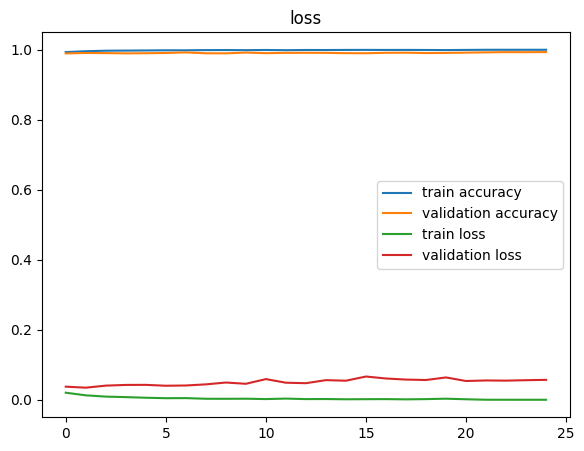

In [4]:
plt.figure(figsize = (15,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "train accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.title("accuracy")
plt.legend()

# loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.title("loss")
plt.legend()

plt.show()

# 2.5. A Note on FL Settings

There are two main settings in Federated Learning, and they establish the system's baseline and perspective with which we look at the wider view of the experiment:

1. The first setting is **cross-device**. The cross-device setup is the probably the first one that first pops up when we think about Federated Learning. This setup is typical of those scenarios where we want to train a model on data that has been obtained by millions upon millions of clients (such as Google Keyboard for instance); these clients are chosen by a technique called *client sampling*, which allows the server to pick specific clients, usually following a broader scheme that is given, for instance, the device must have at least a certain percentage of battery, or the internet connection. In addition to what we just said, during the procedure many *dropouts* are bound to happen (e.g. the phone goes out of battery, or the phone is not connected anymore, that's also why client sampling rules are so important), so we often need to manage those instances so they don't interfer with our process. Another factor important in this type of distributed setting is *latency*, because it is common for these devices (again, simply think about our phones) to have different hardwares, system bloating, OS..., all of these combine and end up causing very real differences in latences between devices involved in the procedure.

2. The second setting is **cross-silo**. We'll see a more practical example in the next notebook, but in a few words the cross-silo setup is used when at hand we have a few but trustworthy clients (e.g., manufacturing companies in the same field that want to share a model for QC). Here, dropouts and latency differences are usually negligible as an assumption (because most times these companies have the necessary tech requirements for the server to do its work smoothly). Also, here client sampling is much more rare (as often these models are shared by say 4/5 companies, so the server just follows the sampling including everyone, except technical issues). One thing worth to mention is the fact that usually the *cross-silo setup relies more on institutional trust and controlled environments, while cross-device FL is typically designed with stronger built-in privacy protections*. For instance, cross-device FL usually show stronger privacy tooling (Differential Privacy, Secure Aggregation...), and this is obviously because we have less natural trust of the client in hand, but sometimes, something slips through, many times causing poisoning attacks from compromised devices, or byzantine clients trying all kinds of malicious stuff (we'll hopefully see this later on). Instead, cross-silo FL relies more on the trust it gives to the participants, but this time sacrificing the security guarantess (often for an enterprise the security tradeoff given by the safety protocols is just not worth it, what matters is the model precision); as we'll talk about more in 2.5_DataSafety, cross-silo setups also means that each client has a larger dataset, meaning more information gets exposed on the gradients, and also less clients means easier time on inversion attacks (especially harmful is cumulative leakage, in which we can end up separating the contributions of one single participant, making the inversion trivial).

# 3. Client Simulation

We can finally start our Federated Learning experiment.

Our first goal is to simulate multiple clients accomplishing their updates locally.

Before keep going with the code there a two main things to note; first of all, in a real life context, we would assume that the *labels* for these problems would be *directly available* (like entered text is automatically labeled for learning a language models, while photo labels simply by their presence in the photos app, this is more so something that happens in a cross-device setting); Secondly we'll assume the clients have **IID data** (independent and identically distributed), this basically means that each client has data drawn from the same distribution (in the next notebook we'll see why it is especially important).

Because we assume IID data, that means we'll need to permutate and shuffle the data so each clients gets an indipendent and identically distributed portion of data (where the name IID comes from); this means that we'll also make sure to import numpy to make our lives easier.

In [5]:
import numpy as np

def create_iid_clients(x,y,num_clients = 5):
    data_size = len(x)
    # shuffle the indices, everything should stay matched
    indices = np.random.permutation(data_size)
    x = x[indices]
    y = y[indices]
    # split the data equally
    split_size = data_size // num_clients
    clients = []
    for i in range(num_clients):
        start = i * split_size
        end = (i+1) * split_size
        clients.append((x[start:end], y[start:end]))
    return clients

iid_clients = create_iid_clients(x_train, y_train, num_clients = 5)

Before we go on further let's check if the dataset has been partitioned in a uniform way

In [6]:
for cid, (cx, cy) in enumerate(iid_clients):
    print(f"Client {cid} label distribution:", np.bincount(cy, minlength = 10))

Client 0 label distribution: [1192 1391 1210 1251 1157 1035 1117 1235 1145 1267]
Client 1 label distribution: [1227 1338 1212 1217 1193 1049 1220 1275 1148 1121]
Client 2 label distribution: [1221 1304 1172 1218 1188 1108 1190 1229 1185 1185]
Client 3 label distribution: [1098 1386 1153 1240 1199 1112 1223 1210 1198 1181]
Client 4 label distribution: [1185 1323 1211 1205 1105 1117 1168 1316 1175 1195]


# 4. Local Training Routine

We now need to start applying the so called *focused collection* or *data minimization*, in other words producing the local updates that will later be aggregated globally.
For this reason the code written below has to follow this pretty simple logical procedure:

* Input: global model weights + client dataset
* Output: locally updated weights after a few epochs

To be more specific, the inputs are global_model (starting Keras model), x_client (numpy array of client inputs), y_client (numpy array of client labels), local_epochs (number of local training epochs), batch_size (training batch size) and as output we obtain the updated weights (as a list of numpy arrays):

In [7]:
def local_update(global_model, cx, cy, local_epochs = 2, batch_size = 32):
    # create a new model and set global weights
    local_model = create_cnn() # we use the same architecture as before
    local_model.set_weights(global_model.get_weights())
    # train locally
    reduce_lr = ReduceLROnPlateau(
        monitor='loss',      
        factor=0.5,
        patience=1,
        min_lr=1e-6,
        verbose=0
    )

    early_stop = EarlyStopping(
        monitor='loss',
        patience=2,
        restore_best_weights=True,
        verbose=0
    )
    
    local_model.fit(cx, cy, epochs = local_epochs, batch_size = batch_size, verbose = 0)
    return local_model.get_weights() # this returns the updated weights

Let's show off a single client example shall we?

We do so by taking only a small amount of samples.

This part has no direct influence on later cells, so it can be safely ignored.

In [8]:
updated_weights = local_update(global_model, cx, cy, local_epochs = 2) # local update

# new model to inspect weights
local_model = create_cnn()
local_model.set_weights(updated_weights)

#let's pick the samples
x_sample = cx[:5]

pred_before = global_model.predict(x_sample)
pred_after = local_model.predict(x_sample)

print("Predictions before local training:\n", np.argmax(pred_before, axis=1))
print("Predictions after local training:\n", np.argmax(pred_after, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predictions before local training:
 [2 8 2 7 8]
Predictions after local training:
 [2 8 2 7 8]


In this case the update from the local update didn't really change the outcome, the model was probably already precise enough

# 5. Federated Averaging

Before going fully into this part we need to talk about *Federated Optimization*.

For Federated Optimization we refer to the optimization problem implicit in federated learning.

In fact, Federated optimization has several properties that distinguish it from a typical optimization problem, such as:

* **non IID** (not our case but still fundamental to mention; as I said it will be tackled in the next notebook)
* **Unbalanced**, because our clients may use some services or apps more than others (someone may take more photos, someone could chat more...)
* **Massively distributed**, because we expect the number of clients participating in the optimization to be superior than the average number of examples per client
* **Limited communication**, mobile devices are sometimes offline, slow (like when they are old or when the battery is near its end) or even lose connection to the server

Usually a synchronous update scheme is assumed, which means it'll proceed in rounds of communication.

There is a fixed set of K clients, each with their own fixed local dataset. At the start of each round, a random fraction C of clients is selected (This for efficiency purposes, there's limited gains from adding more clients after a certain treshold), and the server sends the current global algorithm state to each of these clients. Each selected client then performs local computation based on the global state and its local dataset, and then sends an update to the server.

Now we come at the significance of this chapter; The server can finally apply these updates to its global state and the process repeats.

To do this, we utilize what has now been defined as FederatedAveraging Algorithm (FedAvg in short); in a machine learning context, the objective can be presented as such:
$$
w^{t+1} = \sum_{k=1}^{K} \frac{n_k}{N}\, w_k
$$

$w_k$: the model weights learned by client $k$ after local training

$n_k$: the number of data points on client $k$

$N = \sum_{k=1}^{K} n_k$: total number of data points across all clients

$K$: number of clients

$w^{t+1}$: the new global model after aggregation

We can clearly see that thanks to $n_k/N$ we can basically priotize those clients which have more data, giving it more influence on the overall result.

Obtaining the global model after aggregation is pretty straightforward; as parameters (inputs) we just need the weights list (which contains the weights from each client) and data sizes (because as we said bigger datasets will have more influence, not our case as we assumed a completely simmetrical distribution of datasets between clients).

The output will obviously be the aggregated weights, which is just a list of numpy arrays:

In [9]:
def fedavg(weights_list, data_sizes):

    total_size = np.sum(data_sizes)
    
    # initialize aggregated weights with zeros
    aggregated = [np.zeros_like(w) for w in weights_list[0]]
    
    # weighted sum from the dataset size
    for weights, size in zip(weights_list, data_sizes):
        for i in range(len(weights)):
            aggregated[i] += (size / total_size) * weights[i]
    
    return aggregated

Let's now make an example of running FedAvg on our 5 IID clients; this is basically what is considered round 1:

In [10]:
num_clients = 5
local_epochs = 5

client_weights = []
client_sizes = []

for cid in range(num_clients):
    x_c, y_c = iid_clients[cid]
    
    # store client dataset size
    client_sizes.append(len(x_c))
    
    # local training
    updated_w = local_update(
        model,
        x_c,
        y_c,
        local_epochs=local_epochs,
        batch_size=64
    )
    
    client_weights.append(updated_w)

print("Local updates collected from all clients.")

Local updates collected from all clients.


We can finally actually apply FedAvg to update the global model:

In [11]:
# perform FedAvg
new_global_weights = fedavg(client_weights, client_sizes)

# update model
model.set_weights(new_global_weights)

print("Global model updated with FedAvg.")

Global model updated with FedAvg.


> BIG NOTE: While in data center optimization (centralized), communication costs are relatively small, and computational costs dominate (with GPUs recently becoming the center of reducing the costs), in **federated optimization communication costs dominate**. This is because we are usually limited by the bandwidth and the fact that clients will participate only when many conditions are satisfied, such as when they are fully charged, plugged in, and with a strong wifi connection; on the other hand, because single on-device datasets are pretty small and mobile devices have relatively fast processors (GPUs included), *computation becomes essentially free* when compared to the communication costs. Because computation is the only reducible evil, we can use additional computation in order to decrease the number of communication needed to train a model (which can be done either by increasing parallelism or directly increasing computational power on each client)

# 6. Federated Learning Loop

As I mentioned before, what we did earlier was just a round.

In real applications, this process goes in an iteractive manner (which for obvious reason can't be replicated here); instead, we show what happens to the global model after 25 rounds of this process.

You'll notice that this is just straight up the same thin we repeated earlier, but with a bigger loop, allowing for the effect of the 10 rounds:

In [12]:
# We start off with a fresh global model
global_model = create_cnn()

num_rounds = 25
num_clients = 5
local_epochs = 5

global_acc_history = []

for rnd in range(1, num_rounds + 1):
    print(f"\n Federated Round {rnd}")
    
    client_weights = []
    client_sizes = []
    
    # Send global model to each client and train locally
    for cid in range(num_clients):
        x_c, y_c = iid_clients[cid]
        client_sizes.append(len(x_c))
        
        updated_w = local_update(
            global_model,
            x_c,
            y_c,
            local_epochs=local_epochs,
            batch_size=64
        )
        
        client_weights.append(updated_w)
    
    # Aggregate using FedAvg
    new_global_weights = fedavg(client_weights, client_sizes)
    global_model.set_weights(new_global_weights)
    
    # Evaluate on global test set
    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    global_acc_history.append(acc)
    
    print(f"Global Test Accuracy after round {rnd}: {acc:.4f}")


 Federated Round 1
Global Test Accuracy after round 1: 0.9812

 Federated Round 2
Global Test Accuracy after round 2: 0.9890

 Federated Round 3
Global Test Accuracy after round 3: 0.9903

 Federated Round 4
Global Test Accuracy after round 4: 0.9916

 Federated Round 5
Global Test Accuracy after round 5: 0.9917

 Federated Round 6
Global Test Accuracy after round 6: 0.9926

 Federated Round 7
Global Test Accuracy after round 7: 0.9917

 Federated Round 8
Global Test Accuracy after round 8: 0.9928

 Federated Round 9
Global Test Accuracy after round 9: 0.9924

 Federated Round 10
Global Test Accuracy after round 10: 0.9931

 Federated Round 11
Global Test Accuracy after round 11: 0.9929

 Federated Round 12
Global Test Accuracy after round 12: 0.9931

 Federated Round 13
Global Test Accuracy after round 13: 0.9925

 Federated Round 14
Global Test Accuracy after round 14: 0.9924

 Federated Round 15
Global Test Accuracy after round 15: 0.9919

 Federated Round 16
Global Test Accuracy a

Let's now plot global accuracy across rounds:

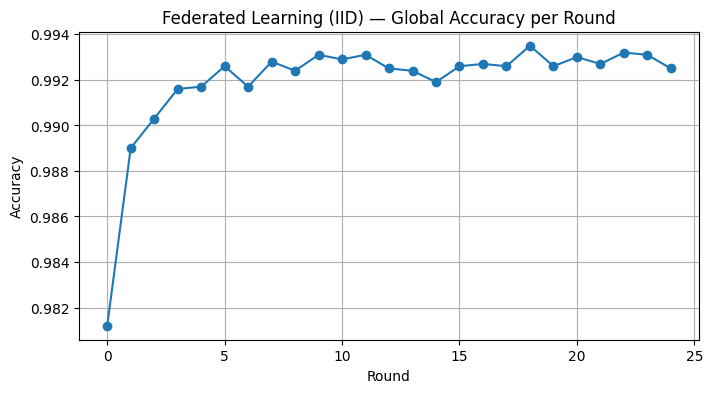

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(global_acc_history, marker='o')
plt.title("Federated Learning (IID) — Global Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# 7. Analysis and observations

We can now plot the global model's accuracy in confront to the baseline model:

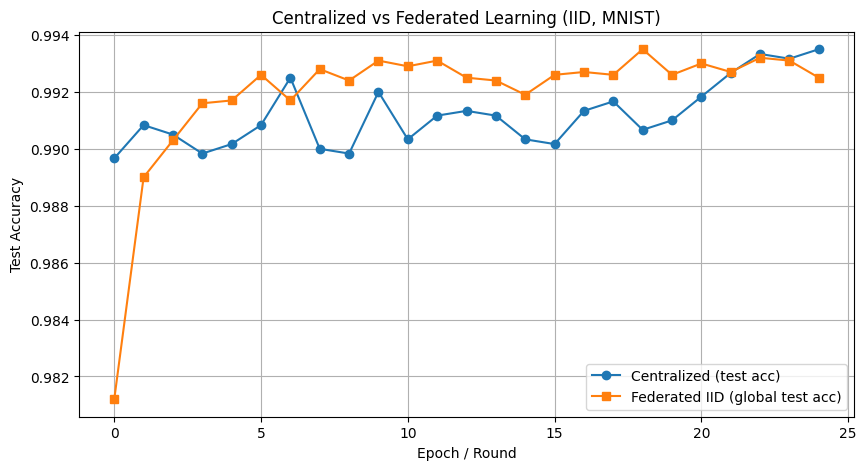

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# centralized baseline accuracy (per epoch)
plt.plot(history.history['val_accuracy'], marker='o', label='Centralized (test acc)')

# Federated IID accuracy (per round)
plt.plot(global_acc_history, marker='s', label='Federated IID (global test acc)')

plt.title("Centralized vs Federated Learning (IID, MNIST)")
plt.xlabel("Epoch / Round")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

There are a few things to notice from the results:

1. **Convergence speed**: centralized training converges way faster because it sees all the data each epoch, while federated learning converges more slowly per round
2. **Accuracy**: With IID data FedAvg reaches almost the same performance as centralized training, actually, for most of the time FedAvg actually has the lead; this is because IID distribution is ideal, and not only it is able to keep the same performance of the centralized training but, thanks to the implicit regularization from the averaging, it is also able to smooth updates and reduce overfitting, acting like an ensemble (it is worth noting that if we increase total number of epochs and number of rounds centralized training will likely be consistently better).
3. **Trade-offs**: First of all more local epochs means fewer communication rounds needed, but risk of client updates drifting slightly (not an issue for IID), while fewer local epochs means more communication rounds needed to reach similar accuracy. Secondly more clients means that each client has less data, so potentially slower convergence, while fewer clients on the other hand means that each client has more data, which could result in updates closer to centralized gradient.
4. **Key Takeaway**: IID distribution is ideal for FedAvg: performance is close to centralized training. The main cost, as we discussed prior, is communication overhead (each round requires sending/receiving model weights).

In [15]:
np.save("centralized_val_acc.npy", history.history['val_accuracy'])
np.save("federated_iid_acc.npy", global_acc_history)

# 8. What next

In the next notebook I'll go more in depth on the significance of non IID data in clients